<a href="https://colab.research.google.com/github/RandaAlsubaie/ny/blob/main/Copy_of_Time_Series_Forecasting_Practical_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout,GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import math

In [2]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 24.8MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [2]:
df=pd.read_csv('/content/Traffic Data.csv',
               parse_dates=True)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,3278.186887,281.162680,0.048396,0.0,49.384600
std,1977.171357,12.661288,0.398007,0.0,39.647341
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1228.750000,271.950000,0.000000,0.0,1.000000
50%,3430.000000,281.825000,0.000000,0.0,75.000000
75%,4928.000000,291.840000,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [5]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [ ]:
# df['clouds_all'].hist(by=df['date_time'], layout=(100,400),figsize=(12,6))

In [ ]:
# df['temp'].hist(by=df['date_time'], layout=(10,40),figsize=(12,6))

In [ ]:
# df['temp'].hist(by=df['traffic_volume'], layout=(10,4),figsize=(12,6))

<Axes: >

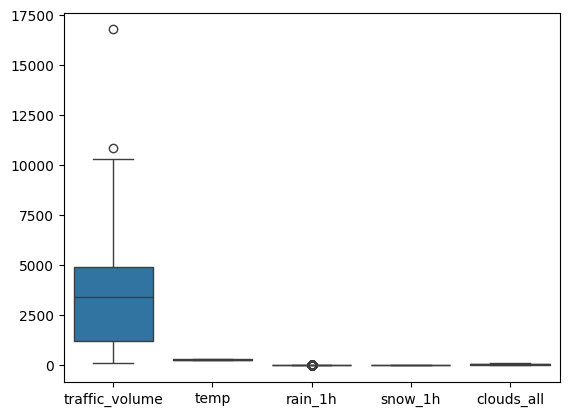

In [6]:
sns.boxplot(data=df)

In [7]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [8]:
remove_outliers(df,'traffic_volume')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [9]:
remove_outliers(df,'temp')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [10]:
remove_outliers(df,'clouds_all')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [11]:
remove_outliers(df,'snow_1h')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [13]:
remove_outliers(df,'rain_1h')

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [14]:
df['date_time'] = df['date_time'].astype('datetime64[ns]')

In [15]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [16]:
df1=df.set_index('date_time')
df1.sort_index(inplace=True)

In [18]:
# df1 = df.resample('M').mode()
# df1 = df.asfreq('M')

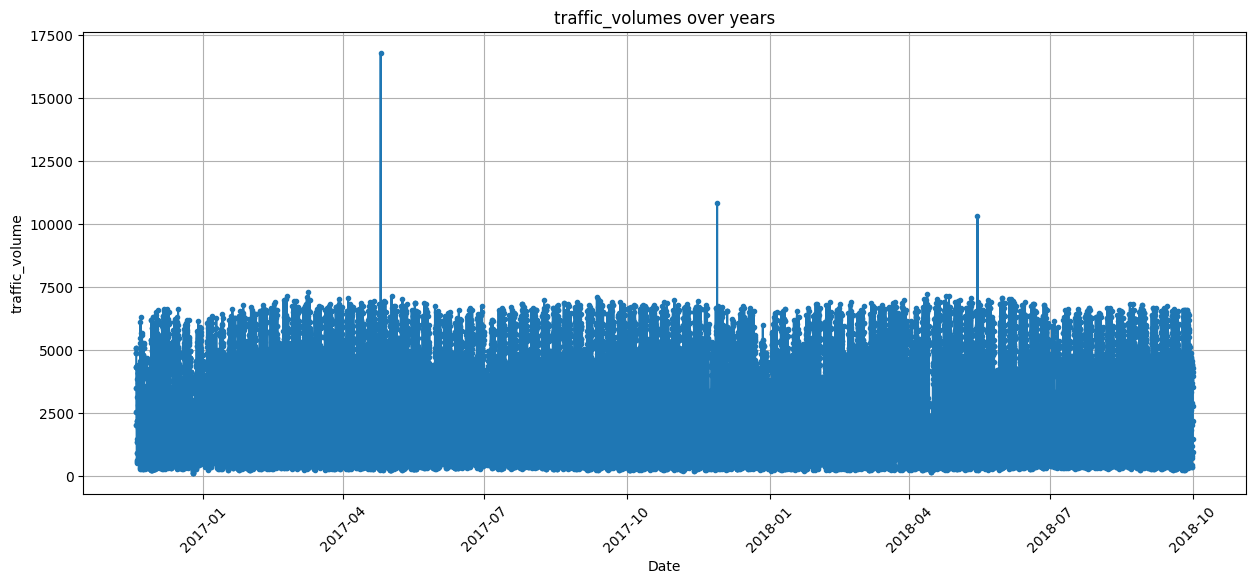

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(df1['traffic_volume'], marker='.')
plt.title('traffic_volumes over years')
plt.xlabel('Date')
plt.ylabel('traffic_volume')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

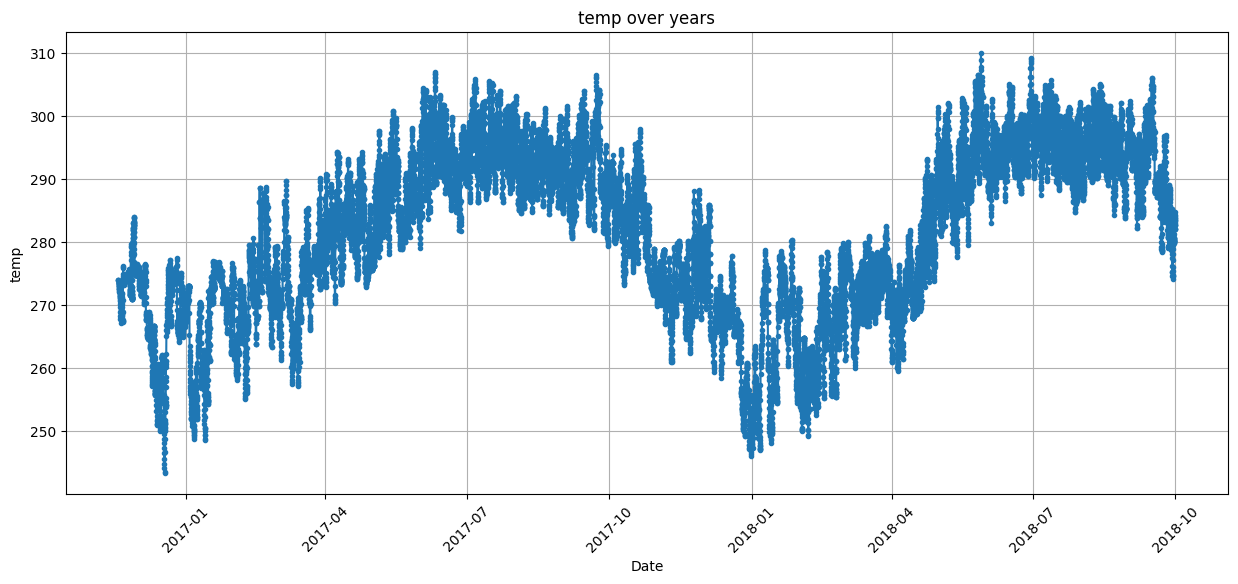

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(df1['temp'], marker='.')
plt.title('temp over years')
plt.xlabel('Date')
plt.ylabel('temp')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

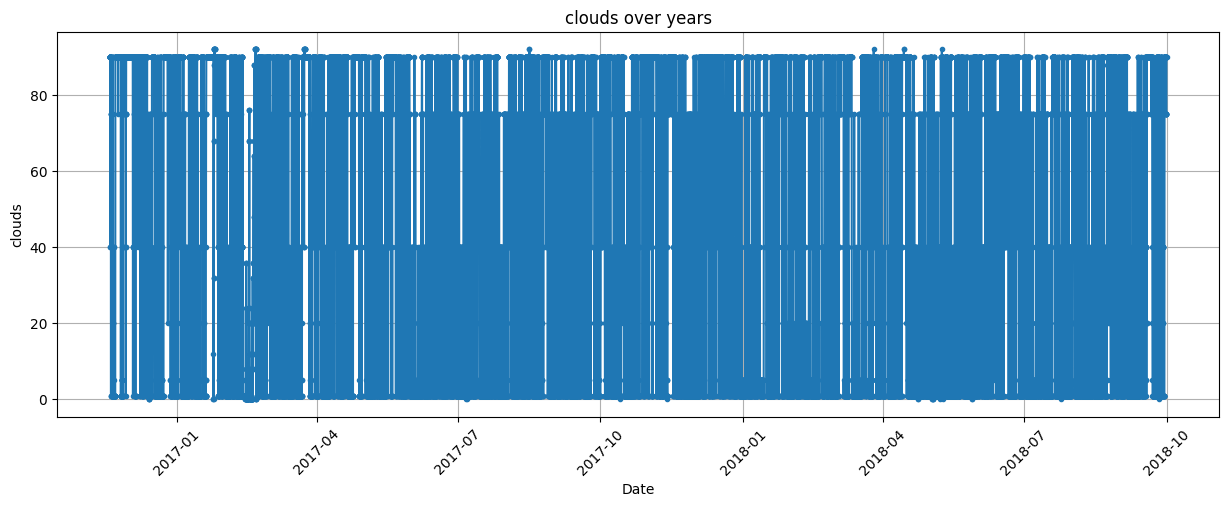

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(df1['clouds_all'], marker='.')
plt.title('clouds over years')
plt.xlabel('Date')
plt.ylabel('clouds')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [24]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time'],
      dtype='object')

In [25]:
# sd = seasonal_decompose(df1['temp'],
#                             model ='additive')

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [26]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [27]:
df.head()
#since the label is traffic_volume i can not fill it with acutal value

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [28]:
df=df.dropna()

In [29]:
df.isnull().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [30]:
df1.duplicated().sum()

18

In [31]:
df1.drop_duplicates()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm


In [32]:
# df1 = df1.resample('M').mode()
# df1 = df1.asfreq('M')

In [33]:
# df1['moving averages']=df1['traffic_volume'].mode()
df1['moving averages']=df1['traffic_volume'].median()

In [34]:
df1['moving averages'].unique()

array([3430.])

In [35]:
df1.sample(5)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,moving averages
date_time,,,,,,,,
2018-02-06 07:00:00,6067.0,249.35,0.0,0.0,1,Mist,mist,3430.0
2018-06-07 19:00:00,3715.0,296.75,0.0,0.0,1,Clear,sky is clear,3430.0
2018-06-03 13:00:00,4563.0,289.08,0.0,0.0,90,Clouds,overcast clouds,3430.0
2016-11-27 19:00:00,3184.0,278.02,0.0,0.0,90,Rain,moderate rain,3430.0
2017-09-22 07:00:00,6778.0,296.43,0.0,0.0,75,Rain,proximity shower rain,3430.0


In [36]:
df1=df.set_index('date_time')
df1.sort_index(inplace=True)

In [37]:
df1.head()
#now its sorted

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Snow,heavy snow
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [38]:
df1['Day_of_week'] = df1.index.dayofweek
df1['month'] = df1.index.month
df1['Day_of_year'] = df1.index.dayofyear
df1['Is_weekends'] = df1.index.weekday // 5
df1['L1'] = df1['temp'].shift(1)
df1['L2'] = df1['temp'].shift(2)
df1['temp'] = df1['temp'].diff()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

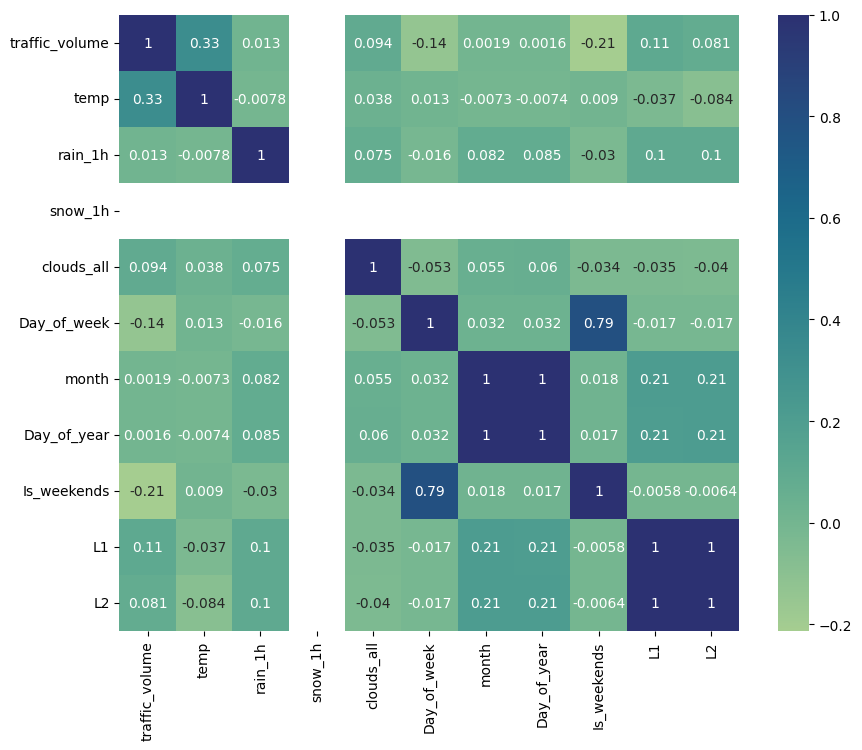

In [39]:
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='crest')
plt.show()

In [40]:
train_size = int(len(df1) * 0.8)
train_data, test_data = df1[:train_size], df1[train_size:]

In [41]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data.iloc[i - n_past:i, 0].values)
    y_train.append(train_data.iloc[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data.iloc[i - n_past:i, 0].values)
    y_test.append(test_data.iloc[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [42]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(X_train).reshape(-1,1))
scaled_data1=scaler.fit_transform(np.array(X_test).reshape(-1,1))

In [45]:
df1=df1.replace('None','')
df1=df1.replace('none','')
df1=df1.dropna()

In [46]:
df1.sample(6)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,Day_of_week,month,Day_of_year,Is_weekends,L1,L2
date_time,,,,,,,,,,,,,
2017-09-06 04:00:00,889.0,-0.50,0.0,0.0,90,Clouds,overcast clouds,2,9,249,0,284.15,284.36
2018-06-06 12:00:00,5098.0,1.67,0.0,0.0,90,Clouds,overcast clouds,2,6,157,0,291.84,290.83
2017-11-15 04:00:00,911.0,0.00,0.0,0.0,90,Fog,fog,2,11,319,0,279.61,279.61
2018-02-02 07:00:00,5843.0,-0.33,0.0,0.0,1,Clear,sky is clear,4,2,33,0,250.35,250.35
2017-08-03 13:00:00,5104.0,0.00,0.0,0.0,90,Rain,light rain,3,8,215,0,285.93,285.93
2016-12-05 06:00:00,5573.0,0.37,0.0,0.0,1,Mist,mist,0,12,340,0,270.14,270.14


In [47]:
X_train.shape

(15924, 60, 1)

In [48]:
y_train.shape

(15924,)

In [49]:
y_test.shape

(3936,)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [51]:
model = Sequential()
model.add(SimpleRNN(units=60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=40))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 60, 60)              │           3,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 60, 50)              │           5,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 40)                  │           3,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,951 (50.59 KB)

 Trainable params: 12,951 (50.59 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model2 = Sequential()


model2.add(GRU(units=60, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(GRU(units=50, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(GRU(units=40))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 60, 60)              │          11,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 60, 50)              │          16,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 40)                  │          11,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,221 (153.21 KB)

 Trainable params: 39,221 (153.21 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
model2.compile(loss='mean_squared_error', optimizer='adam')

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [57]:
model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=50
          )

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - loss: 14508027.0000 - val_loss: 14831515.0000
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 14510283.0000 - val_loss: 14744198.0000
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 14407596.0000 - val_loss: 14658023.0000
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 28s 83ms/step - loss: 14432403.0000 - val_loss: 14572660.0000
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 14307236.0000 - val_loss: 14487829.0000
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - loss: 13964651.0000 - val_loss: 14403474.0000
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 14021444.0000 - val_loss: 14319737.0000
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - loss: 14237675.0000 - val_loss: 14236415.0000
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 14032222.0000 - val_loss: 14153550.0000
Epoch 10/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 13786176.0000 - val

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [58]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [59]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [60]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

934927.690823265
934851.8290329201


In [64]:
# look_back = 55

# trainPredictPlot = np.empty_like(df1)
# trainPredictPlot[:] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# testPredictPlot = np.empty_like(df1)
# testPredictPlot[:] = np.nan

# test_start = len(df1) - len(test_predict)
# testPredictPlot[test_start:] = test_predict.flatten()

# scaled_data = scaler.inverse_transform(scaled_data)

# plt.figure(figsize=(15, 6))
# plt.plot(scaled_data, color='black', label=f"Actual {traffic_volume} traffic_volume")
# plt.plot(trainPredictPlot, color='red', label=f"Predicted {traffic_volume} traffic_volume(train set)")
# plt.plot(testPredictPlot, color='blue', label=f"Predicted {traffic_volume} traffic_volume(test set)")

# plt.title(f"{traffic_volume} traffic_volume over time ")
# plt.xlabel("Date time")
# plt.ylabel(f"{traffic_volume} traffic_volume")
# plt.legend()
# plt.show()

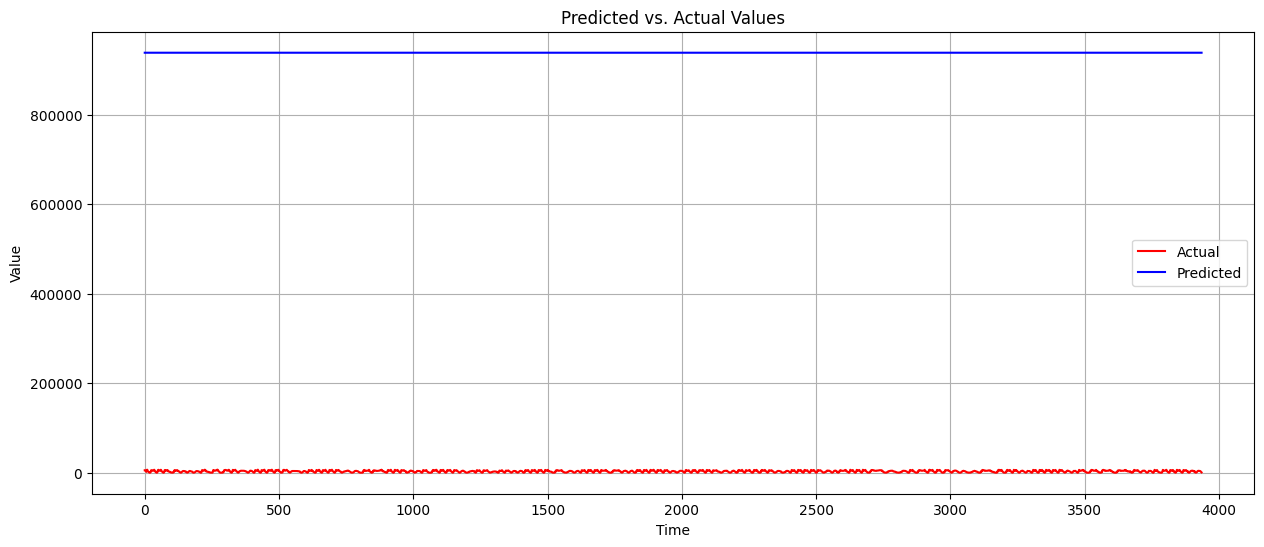

In [63]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [68]:
model2.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=10,
          batch_size=50
          )

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 53s 144ms/step - loss: 14410400.0000 - val_loss: 14825489.0000
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step - loss: 14418392.0000 - val_loss: 14738125.0000
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 14402689.0000 - val_loss: 14652050.0000
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 83s 146ms/step - loss: 14243093.0000 - val_loss: 14566695.0000
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - loss: 14144037.0000 - val_loss: 14482000.0000
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - loss: 14230282.0000 - val_loss: 14397836.0000
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - loss: 14024125.0000 - val_loss: 14314072.0000
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 83s 146ms/step - loss: 13941870.0000 - val_loss: 14230676.0000
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - loss: 13978724.0000 - val_loss: 14147770.0000
Epoch 10/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 46s 143ms/step - loss: 13746454.

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [69]:
train_predict=model2.predict(X_train)
test_predict=model2.predict(X_test)

498/498 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [70]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [71]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

941066.6672672629
940990.8062542119


In [72]:
# look_back = 55

# trainPredictPlot = np.empty_like(df1)
# trainPredictPlot[:] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# testPredictPlot = np.empty_like(df1)
# testPredictPlot[:] = np.nan

# test_start = len(df1) - len(test_predict)
# testPredictPlot[test_start:] = test_predict.flatten()

# scaled_data = scaler.inverse_transform(scaled_data)

# plt.figure(figsize=(15, 6))
# plt.plot(scaled_data, color='black', label=f"Actual {traffic_volume} traffic_volume")
# plt.plot(trainPredictPlot, color='red', label=f"Predicted {traffic_volume} traffic_volume(train set)")
# plt.plot(testPredictPlot, color='blue', label=f"Predicted {traffic_volume} traffic_volume(test set)")

# plt.title(f"{traffic_volume} traffic_volume over time ")
# plt.xlabel("Date time")
# plt.ylabel(f"{traffic_volume} traffic_volume")
# plt.legend()
# plt.show()

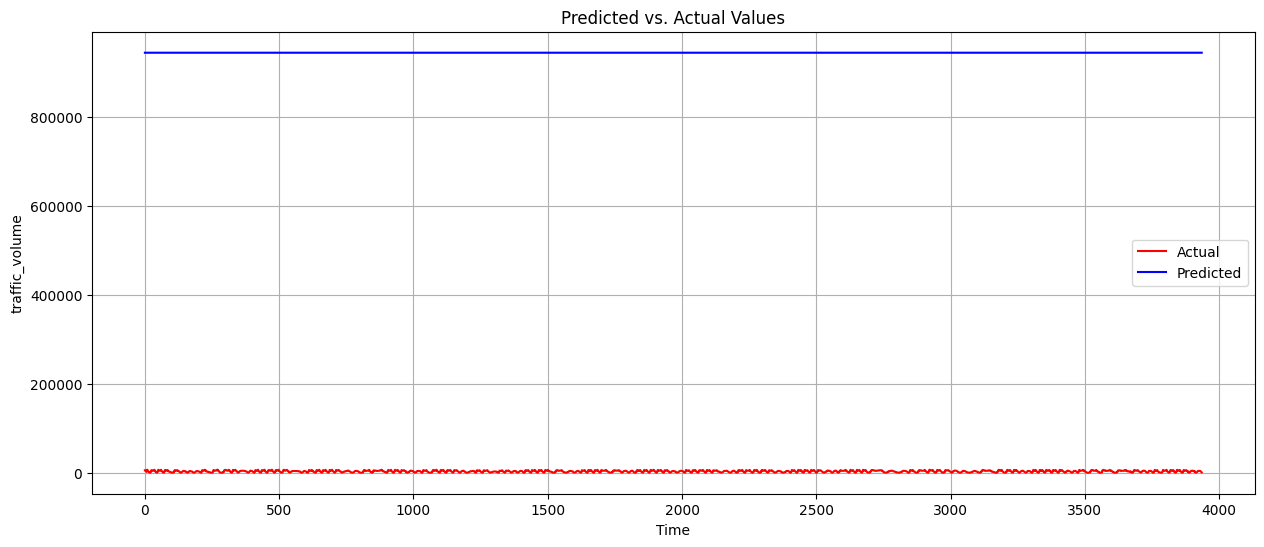

In [73]:
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('traffic_volume')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
Data Preprocessing handling misisng values cause when i scale it must be no null values my models are  Underfitting because its not learn at all
i think when i use smaller number of batch size will better also using larger number of epochs
```
# This is formatted as code
```

